In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import sparse_categorical_crossentropy
import numpy as np

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
71850,I know what happens next.,Je sais ce qui se passe ensuite.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
158410,I can't believe you actually said that.,Je n'arrive pas à croire que vous ayez vraimen...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
40067,Why didn't Tom move?,Pourquoi Tom n'a-t-il pas bougé ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
140918,I don't think that's a coincidence.,Je ne pense pas que cela soit une coïncidence.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
153913,Have you ever done any volunteer work?,Avez-vous jamais effectué un travail volontaire ?,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines.sample(5)

,eng,fra
29710,I felt responsible.,Je me suis senti responsable.
25080,It was depressing.,C'était déprimant.
18780,I hope it's true.,J'espère que c'est vrai.
19643,Isn't that awful?,N'est-ce pas horrible ?
1399,Say hello.,Dis bonjour.


In [4]:
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
12559,We're all done.,Nous en avons complètement fini.
12652,"Well done, Tom.","Bien joué, Tom."
21443,Watch your speed.,Surveille ta vitesse.
12163,Tom is packing.,Tom fait ses valises.
13548,Expect no mercy.,N'espère aucune pitié !


In [5]:
lines.fra

0                                      Va !
1                                   Marche.
2                                En route !
3                                   Bouge !
4                                   Salut !
                        ...                
32995    Nous avons toutes beaucoup pleuré.
32996                Nous avions tous faim.
32997         Nous avons aussi trouvé ceci.
32998         Nous sommes des gens occupés.
32999         Nous regardons la télévision.
Name: fra, Length: 33000, dtype: object

## 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [6]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip() 
    return sentence

import re
def preprocess_sentence2(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip()
    sentence = "<sos> " + sentence + " <eos>"
    return sentence


In [7]:
line = []

for a in lines.fra:
    preprocessed_sentence = preprocess_sentence2(a)
    line.append(preprocessed_sentence)
line[:10]

['<sos> va ! <eos>',
 '<sos> marche . <eos>',
 '<sos> en route ! <eos>',
 '<sos> bouge ! <eos>',
 '<sos> salut ! <eos>',
 '<sos> salut . <eos>',
 '<sos> cours ! <eos>',
 '<sos> courez ! <eos>',
 '<sos> prenez vos jambes vos cous ! <eos>',
 '<sos> file ! <eos>']

In [8]:
line2 = []

for a in lines.eng:
    preprocessed_sentence = preprocess_sentence(a)
    line2.append(preprocessed_sentence)
line2[:10]

['go .',
 'go .',
 'go .',
 'go .',
 'hi .',
 'hi .',
 'run !',
 'run !',
 'run !',
 'run !']

## 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [9]:
eng_tokenizer = Tokenizer(char_level=False, filters = '')   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(line2)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(line2)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[25, 1],
 [25, 1],
 [25, 1],
 [25, 1],
 [782, 1],
 [782, 1],
 [207, 20],
 [207, 20],
 [207, 20],
 [207, 20]]

In [10]:
fra_tokenizer = Tokenizer(char_level=False, filters = '')  #char_level=False, # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(line)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(line)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 70, 7, 2],
 [1, 384, 3, 2],
 [1, 26, 541, 7, 2],
 [1, 754, 7, 2],
 [1, 789, 7, 2],
 [1, 789, 3, 2],
 [1, 694, 7, 2],
 [1, 1953, 7, 2],
 [1, 194, 282, 1097, 282, 2727, 7, 2],
 [1, 1541, 7, 2]]

In [11]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972


In [12]:
# 훈련 후 결과 비교할때 사용
src_to_index= eng_tokenizer.word_index
index_to_src= eng_tokenizer.index_word
# 훈련 후 예측 과정에서 사용
# 훈련 후 결과 비교할 때 사용
tar_to_index= fra_tokenizer.word_index
index_to_tar= fra_tokenizer.index_word


In [13]:
max_eng_seq_len = max([len(line2) for line2 in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


## 디코더의 문장에 시작 토큰과 종료 토큰을 넣고, 종료 토큰, 시작 토큰 제거

In [14]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index['<eos>'] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index['<sos>'] ] for line in target_text]

In [15]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_target[:3])

[[25, 1], [25, 1], [25, 1]]
[[1, 70, 7], [1, 384, 3], [1, 26, 541, 7]]
[[70, 7, 2], [384, 3, 2], [26, 541, 7, 2]]


In [16]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [17]:
print(encoder_input[0])

[25  1  0  0  0  0  0  0]


In [18]:
encoder_input[0]

array([25,  1,  0,  0,  0,  0,  0,  0], dtype=int32)

In [19]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 16)
훈련 target 레이블의 크기 : (30000, 16)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 16)
테스트 target 레이블의 크기 : (3000, 16)


## 임베딩 층(Embedding layer) 사용하기

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [21]:
latent_dim = 64

In [22]:
# 인코더
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_emb = Embedding(eng_vocab_size, latent_dim)(encoder_inputs)
encoder_masking =Masking(mask_value=0.0)(encoder_emb)
encoder_lstm = LSTM(latent_dim, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_masking)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [23]:
# 디코더
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_emb_layer = Embedding(fra_vocab_size, latent_dim)
decoder_emb = decoder_emb_layer(decoder_inputs)
decoder_masking =Masking(mask_value=0.0)(decoder_emb)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_masking, initial_state = encoder_states)

In [24]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## 모델 구현

In [25]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     305344      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     510208      input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 16s 34ms/step - loss: 2.7744 - acc: 0.6479 - val_loss: 2.0625 - val_acc: 0.7097
Epoch 2/50
235/235 [==============================] - 6s 25ms/step - loss: 1.6307 - acc: 0.7496 - val_loss: 1.8702 - val_acc: 0.7243
Epoch 3/50
235/235 [==============================] - 6s 25ms/step - loss: 1.4903 - acc: 0.7615 - val_loss: 1.7864 - val_acc: 0.7335
Epoch 4/50
235/235 [==============================] - 6s 25ms/step - loss: 1.3814 - acc: 0.7794 - val_loss: 1.6971 - val_acc: 0.7423
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 1.2934 - acc: 0.7929 - val_loss: 1.6207 - val_acc: 0.7553
Epoch 6/50
235/235 [==============================] - 6s 25ms/step - loss: 1.2261 - acc: 0.8035 - val_loss: 1.5754 - val_acc: 0.7619
Epoch 7/50
235/235 [==============================] - 6s 25ms/step - loss: 1.1749 - acc: 0.8111 - val_loss: 1.5220 - val_acc: 0.7718
Epoch 8/50
235/235 [==============================] - 6s 25ms/step -

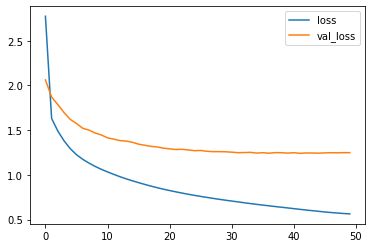

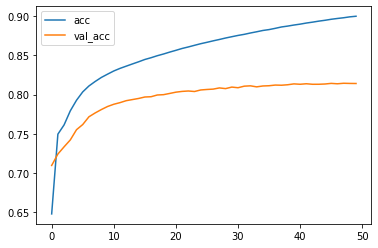

In [27]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df['loss'].plot()
history_df['val_loss'].plot()
plt.legend()
plt.show()


history_df = pd.DataFrame(history.history)
history_df['acc'].plot()
history_df['val_acc'].plot()
plt.legend()
plt.show()

## 모델 평가하기

In [28]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
# 디코더
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h,decoder_state_input_c]

dec_emb2 = decoder_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state= decoder_state_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [29]:
# 디코더 정의
decoder_model = Model([decoder_inputs]+decoder_state_inputs,[decoder_outputs2]+decoder_states2)

In [30]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <sos>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = tar_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [31]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp=temp+index_to_src[i]+ ' '
    return temp
# 변역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i != tar_to_index['<sos>']) and i != tar_to_index['<eos>']):
            temp=temp+index_to_tar[i]+ ' '
    return temp

In [32]:
import numpy as np
for seq_index in  [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_train[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_train[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: go . 
정답 문장: bouge ! 
번역기가 번역한 문장:  va en homme . 
-----------------------------------
입력 문장: hello ! 
정답 문장: bonjour ! 
번역기가 번역한 문장:  salut ! 
-----------------------------------
입력 문장: got it ? 
정답 문장: t'as capt ? 
번역기가 번역한 문장:  qu'est ce qu
-----------------------------------
입력 문장: hang on . 
정답 문장: tiens bon ! 
번역기가 번역한 문장:  attendez . 
-----------------------------------
입력 문장: here's . 
정답 문장: voil cinq dollars . 
번역기가 번역한 문장:  voici l . 


In [33]:
for seq_index in  [1, 250, 431, 105,322]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: i lost your number . 
정답 문장: j'ai perdu votre num ro . 
번역기가 번역한 문장:  j'ai tr s a
-----------------------------------
입력 문장: i think you did it . 
정답 문장: je pense que c'est toi qui l'a fait . 
번역기가 번역한 문장:  je pense que 
-----------------------------------
입력 문장: i won't say a word . 
정답 문장: je ne dirai pas un mot . 
번역기가 번역한 문장:  je ne fais pas m
-----------------------------------
입력 문장: i never was skinny . 
정답 문장: je n'ai jamais t maigre . 
번역기가 번역한 문장:  je ne suis pa
-----------------------------------
입력 문장: i want to tell you . 
정답 문장: je veux vous le dire . 
번역기가 번역한 문장:  je veux le v


-----------------------------------
입력 문장: i lost your number . -> 나는 너의 번호를 잃어버렸다.

정답 문장: j'ai perdu votre num ro . -> 나는 너의 번호를 잃어버렸다.

번역기가 번역한 문장:  j'ai tr s a -> 난 너무 많아.

-----------------------------------
입력 문장: i think you did it . -> 네가 해낸 것 같아.

정답 문장: je pense que c'est toi qui l'a fait . -> 네가 해낸 것 같아.

번역기가 번역한 문장:  je pense que -> 나는 생각한다

-----------------------------------
입력 문장: i won't say a word . -> 난 한 마디도 안 할 것이다.

정답 문장: je ne dirai pas un mot .  -> 난 한 마디도 안 할 것이다.

번역기가 번역한 문장:  je ne peux pas m -> 난 안 해.

----------------------------------- 
입력 문장: i never was skinny . -> 나는 결코 말랐던 적이 없다.

정답 문장: je n'ai jamais t maigre . -> 나는 결코 말랐던 적이 없다.

번역기가 번역한 문장: je ne suis pa -> 전 그렇지 않아요.

-----------------------------------
입력 문장: i want to tell you . -> 나는 너에게 말하고 싶다.

정답 문장: je veux vous le dire . -> 나는 너에게 말하고 싶다.

번역기가 번역한 문장:  je veux le v -> 난 그를 원한다.

## 회고
- 어려웠던 점 : encoder와 decoder을 구분해서 model을 구현하는게 어려웠다.
- 알아낸 점 및 모호한 점 : 마지막 출력 시킬때, encoder_input과 decoder_input을 잘 구분해서 적어야하는 것을 알게 되었다.
- 노력한 점 : val_loss가 우하향하는 모습을 보도록 그래프를 그렸다.
- 자기다짐 : 번역기를 또 한글로 바꾸는 점이 힘들었지만, 완성도 있는 번역기를 확인 할 수 있어서 좋았다.